# Imports

In [359]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
import os

# 1.1 Getting Correspondences
<p>We will be using the SIFT descriptor as it is able to do both Feature Extraction/Detection and Feature description, and from the feature descriptors, we can easily match the features. </p>

<p>We will apply the SIFT descriptor on the first frame of the book.mov and cv_cover.jpg. </p>

<h3> Few Notes</h3>

<p>In SIFT, we use gray-scale image, because SIFT heavily relies on gradient calculations to extract features like blobs, so SIFT just relies on intensity values and does not care about color. This also improves performance.</p> 
<p>So the gray-scale conversion is just to make the algorithm work efficiently and focus on structure (edges/corners), not color.</p>

<p>Gaussian Pyramid note:  
<ul>
<li>Multiple scales of image with one Gaussian sigma</li>
<li>is the same as multiple sigmas of gaussian on one scale of image</li>
</ul>
</p>

In [360]:
def read_image(image_relative_path):
    root = os.getcwd()
    imgPath = os.path.join(root, image_relative_path)
    
    # read image
    img = cv.imread(imgPath)
    
    return img

In [361]:
def get_frame(frame_num,capture):
    # set the frame position
    capture.set(cv.CAP_PROP_POS_FRAMES, frame_num)
    
    # read the frame
    ret, frame = capture.read()
    
    return ret, frame

In [362]:
def image2gray(image):
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

In [363]:
def SIFT(image):

    # image in gray scale
    imgGray = image2gray(image)

    # create sift
    sift = cv.SIFT_create()

    # find keypoints and descriptors
    keypoints, descriptors = sift.detectAndCompute(imgGray, None)  # binary mask= None (none means don't exclude any pixels)

    # draw keypoints
    imgKeypoints = cv.drawKeypoints(imgGray, keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # show image
    plt.imshow(imgKeypoints)
    plt.axis('off')
    plt.title('SIFT Keypoints')
    plt.show()

    return keypoints, descriptors

In [364]:
def knnBruteForce(descriptor1,descriptor2,keypoints1,keypoints2):
    # create brute force matcher
    bf = cv.BFMatcher() # default match is L2 Distance, which is good for SIFT
    nNeighbors = 2
    matches = bf.knnMatch(descriptor1, descriptor2, k=nNeighbors) # get best 2 matches of each key-point is descriptor1
    # matches is best 2 matches in descriptor2 for each key-point in descriptor1

    goodMatches_50 = [None] * 50 # to drawMatchesKnn, it expects a list of lists of DMatch objects
    # DMatch objects hold the two matched points and the distance between them
    src_pts = [None] * 50 # to hold the coordinates of the keypoints in descriptor1
    dst_pts = [None] * 50 # to hold the coordinates of the keypoints in descriptor2
    # we need the coordinates of the keypoints for the homography matrix

    testRatio = 0.75 # ratio test to filter out bad matches (Lowe's ratio test)
    i = 0
    for m, n in matches: # m is best match, and n is second best (m and n are keypoints in img2)
        if m.distance < testRatio * n.distance:
            goodMatches_50[i] = [m] # to drawMatchesKnn, it expects a list of lists of DMatch objects
            src_pts[i] = keypoints1[m.queryIdx].pt # m.queryIdx is the index of the keypoint in descriptor1
            dst_pts[i] = keypoints2[m.trainIdx].pt # m.trainIdx is the index of the keypoint in descriptor2
            i+=1
            if i == 50: # we only want 50 matches
                print("Found 50 good matches")            
                break
    
    return goodMatches_50, src_pts, dst_pts


In [365]:
def drawMatches(img1, img2, kp1, kp2, goodMatches):
    imgMatch = cv.drawMatchesKnn(
        img1, kp1, img2, kp2, goodMatches, None,
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure()
    plt.imshow(imgMatch)
    plt.axis('off')
    plt.title('Matches')
    plt.show()

In [366]:
# def knnBruteForce2a(descriptor1, kp1, descriptor2, kp2):
#     # Create Brute-Force matcher with default settings (L2 norm for SIFT)
#     bf = cv.BFMatcher()
#     matches = bf.knnMatch(descriptor1, descriptor2, k=2)

#     goodMatches = []
#     src_pts = []  
#     dst_pts = []
#     testRatio = 0.3

#     for m, n in matches:
#         if m.distance < testRatio * n.distance:
#             goodMatches.append(m)  # Just append the best match, not [m]
#             src_pts.append(kp1[m.queryIdx].pt)  # Append the point from the first image
#             dst_pts.append(kp2[m.trainIdx].pt)  # Append the point from the second image
#             if len(goodMatches) == 50:
#                 print("Found 50 good matches")
#                 break

#     # Extract corresponding points from the good matches
#     # src_pts = np.float32([kp1[m.queryIdx].pt for m in goodMatches])
#     # dst_pts = np.float32([kp2[m.trainIdx].pt for m in goodMatches])

#     return goodMatches, src_pts, dst_pts



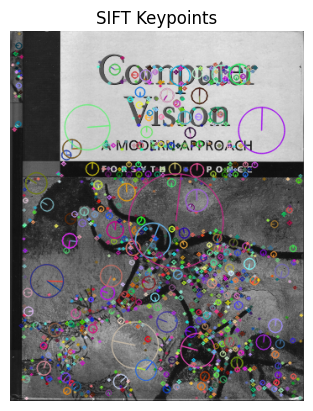

In [367]:
image1 = read_image('assignment_2_materials\\Part_1\\cv_cover.jpg')
keypoints1, descriptor1 = SIFT(image1)

In [368]:
# Load the video
cap = cv.VideoCapture('assignment_2_materials\\Part_1\\book.mov')
total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
print(total_frames)

641


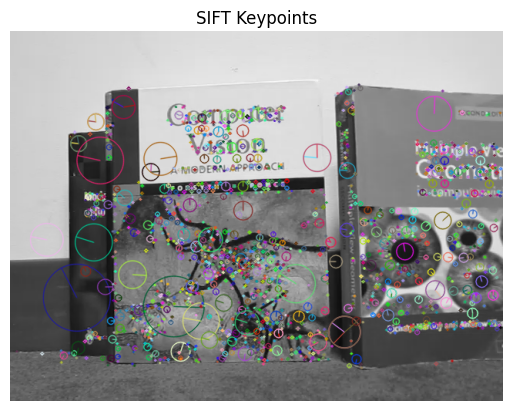

In [369]:
frame_num = 0
# Read the frame
ret, frame = get_frame(frame_num, cap)

if ret:
    keypoints2, descriptor2 = SIFT(frame)

Found 50 good matches


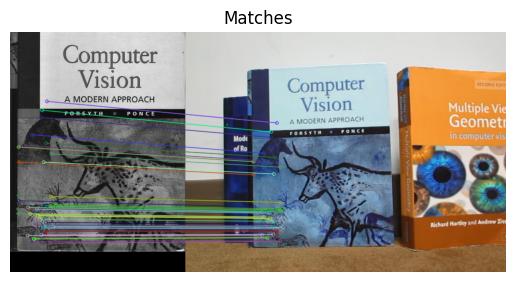

In [370]:
matches, source_points, dest_points = knnBruteForce(descriptor1, descriptor2, keypoints1, keypoints2)
# Draw matches
drawMatches(image1, frame, keypoints1, keypoints2, matches)

In [371]:
source_points[0] # 2d coordinates

(15.683753967285156, 353.9227600097656)

In [372]:
dest_points[0]

(136.59677124023438, 362.03521728515625)

In [373]:
# goodMatches1 ,kp1 ,kp2 = knnBruteForce2a(descriptor1, keypoints1 ,descriptor2, keypoints2)
# coloredFrame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
# goodMatches2 = knnBruteForce(descriptor1, descriptor2)
# # drawMatches(image1, coloredFrame, keypoints1 , keypoints2, goodMatches1)
# imgMatch = cv.drawMatches(image1, keypoints1, coloredFrame, keypoints2, goodMatches1, None,
#                          flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# plt.figure()
# plt.imshow(imgMatch)
# plt.axis('off')
# plt.title('Matches')
# plt.show()

# 1.2 Compute Homography Parameters

In [374]:
# SHADI
def compute_homography(src_pts, dst_pts):
    """
    Compute 3x3 homography matrix H such that dst = H * src
    Args:
        src_pts: List of source points [(x1, y1), (x2, y2), ...]
        dst_pts: List of destination points [(x1', y1'), (x2', y2'), ...]
    Returns:
        3x3 homography matrix
    """
    assert len(src_pts) >= 4 and len(src_pts) == len(dst_pts)
    # Solved using Ah = 0
    # Convert to umpy arnrays if they aren't already
    src_pts = np.array(src_pts, dtype=np.float64)   # Ensure float64 for precision
    dst_pts = np.array(dst_pts, dtype=np.float64)

    A = []
    for (x, y), (x_, y_) in zip(src_pts, dst_pts):   # in each iteration we create A_i and append it to A
        A.append([-x, -y, -1, 0, 0, 0, x*x_, y*x_, x_]) # A_i size is 2*9
        A.append([0, 0, 0, -x, -y, -1, x*y_, y*y_, y_]) # for each correspondence we have 1 A_i
        # we said above at least 4 correspondences -> at least 4 A_is

    # N is number of correspondences
    A = np.array(A) # 2N* 9 matrix
    # We need to solve Ah = 0, where h is a vector of size 9

    # Solve using SVD
    U, S, Vt = np.linalg.svd(A) # Singular Value Decomposition: A = USV^T

    '''
    U: Left singular vectors (an orthogonal matrix)
    S: Singular values (diagonal matrix)(a vector of singular values )
    Vt: Right singular vectors (transpose)(transpose of an orthogonal matrix)
    '''

    # The solution h is the last column of V (or last row of Vt)
    h = Vt[-1]

    # Normalize h
    h = h / h[-1] # Dividing by h9 to make it 1

    H = h.reshape((3, 3)) 
    return H

In [375]:
def verify_homography(H, src_pts, dst_pts):
    """Check how well H transforms src_pts to dst_pts"""
    src_hom = np.column_stack([src_pts, np.ones(len(src_pts))]) # Convert to homogeneous coordinates 3*1
    projected = (H @ src_hom.T).T #Applies the homography matrix H to the homogeneous source points
    projected /= projected[:, 2:]  # Normalize to get back to 2D coordinates
    
    errors = np.linalg.norm(projected[:, :2] - dst_pts, axis=1) # Calculate the Euclidean distance between projected points and actual destination points
    print(f"Mean reprojection error: {np.mean(errors):.2f} pixels")
    return errors

In [376]:
# Usage:
H = compute_homography(source_points, dest_points)
errors = verify_homography(H, source_points, dest_points)
H

Mean reprojection error: 0.63 pixels


array([[ 7.57234047e-01,  8.09368872e-03,  1.19673898e+02],
       [-1.04106492e-01,  7.99015704e-01,  7.58833687e+01],
       [-2.36923822e-04, -3.16111105e-05,  1.00000000e+00]])

<h3> Collecting Points for Verification</h3>

In [377]:
collected_points = []

def click_event(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        print(f"Point selected: ({x}, {y})")
        collected_points.append((x, y))
        # Optional: show the point on the image
        cv.circle(param, (x, y), 3, (0, 0, 255), -1)
        cv.imshow("Original Image P", param)


# Show image and set callback
image1_copy = image1.copy()
cv.imshow("Original Image P", image1_copy)
cv.setMouseCallback("Original Image P", click_event, image1_copy)

print("Click on the image to select points. Press ESC when done.")

# Wait until ESC key
while True:
    key = cv.waitKey(1) & 0xFF
    if key == 27:  # ESC key
        break

cv.destroyAllWindows()

# Now `collected_points` contains all clicked points
print("Points collected:", collected_points)

Click on the image to select points. Press ESC when done.


KeyboardInterrupt: 

In [ ]:
def map_points(H, src_pts):
    """
    Maps points from src_pts (source points) to dst_pts (destination points)
    using the homography matrix H.
    """
    mapped_pts = []
    for pt in src_pts:
        pt_homogeneous = np.array([pt[0], pt[1], 1])  # Convert to homogeneous coordinates
        mapped_pt = H.dot(pt_homogeneous)  # Apply homography matrix

        # Convert back from homogeneous to non-homogeneous coordinates
        mapped_pt = mapped_pt / mapped_pt[2]  
        mapped_pts.append(mapped_pt[:2])  # Return only x, y coordinates
    return mapped_pts


In [ ]:
mapped_points = map_points(H,collected_points)
len(mapped_points)

19

In [ ]:
mapped_points = np.array(mapped_points)

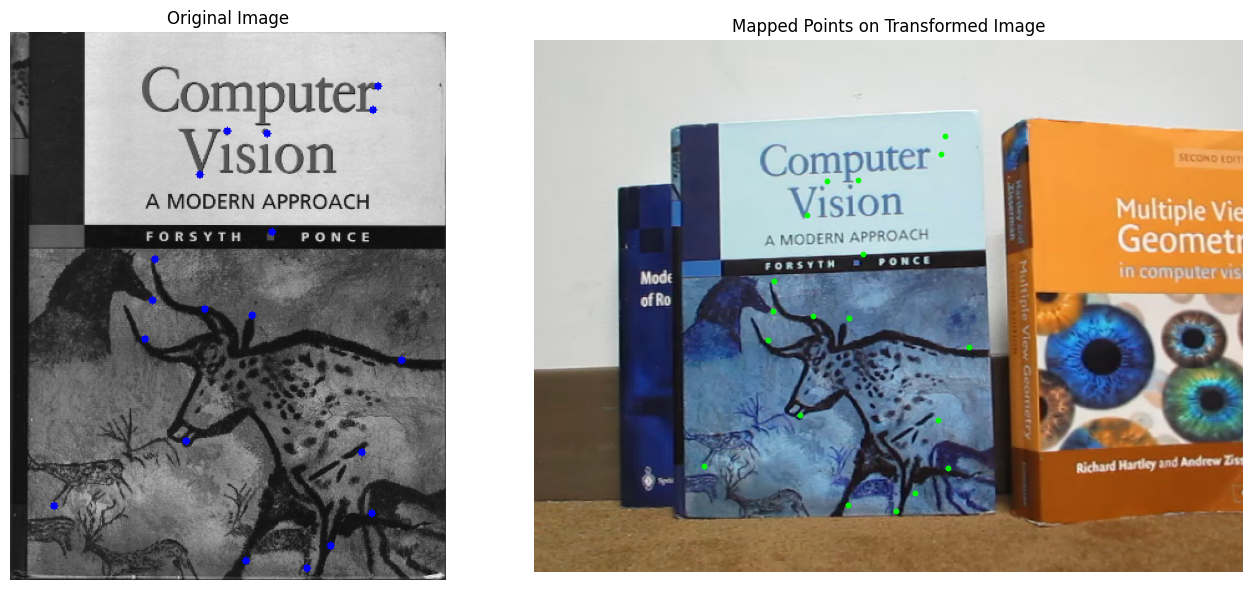

In [ ]:
frame_copy = frame.copy()
# Convert BGR to RGB for matplotlib
frame_copy_rgb = cv.cvtColor(frame_copy, cv.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Image 1 (original)
axes[0].imshow(image1_copy)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Image 2 (transformed with mapped points)
axes[1].imshow(frame_copy)
axes[1].scatter(mapped_points[:, 0], mapped_points[:, 1], c='lime', marker='o', s=10)
axes[1].set_title("Mapped Points on Transformed Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# def compute_homography(src_pts, dst_pts):
#     """
#     Compute 3x3 homography matrix H such that dst = H * src
#     Args:
#         src_pts: List of source points [(x1, y1), (x2, y2), ...]
#         dst_pts: List of destination points [(x1', y1'), (x2', y2'), ...]
#     Returns:
#         3x3 homography matrix
#     """
#     assert len(src_pts) >= 4 and len(src_pts) == len(dst_pts)

#     # Convert to numpy arrays if they aren't already
#     src_pts = np.array(src_pts, dtype=np.float64)   # Ensure float64 for precision
#     dst_pts = np.array(dst_pts, dtype=np.float64)

#     A = []
#     for (x, y), (x_p, y_p) in zip(src_pts, dst_pts):    #zip pairs each src point with its matching dst point
#         A.append([-x, -y, -1, 0, 0, 0, x*x_p, y*x_p])
#         A.append([0, 0, 0, -x, -y, -1, x*y_p, y*y_p])

#     A = np.array(A) # 2N* 8 matrix
#     b = np.concatenate([dst_pts[:, 0], dst_pts[:, 1]])  # [x1',x2',...,y1',y2',...]

#     # Solve using SVD for better numerical stability
#     U, S, Vt = np.linalg.svd(A) # Singular Value Decomposition
#     '''
#     U: Left singular vectors (an orthogonal matrix)
#     S: Singular values (diagonal matrix)(a vector of singular values )
#     Vt: Right singular vectors (transpose)(transpose of an orthogonal matrix)
#     '''
#     H = Vt[-1, :] / Vt[-1, -1] #This computes the homography matrix H from the results of SVD
#     '''
#     Vt[-1, :]	Last singular vector -> solution of Ah = 0
#     / Vt[-1, -1]	Normalize the vector to set H[2][2] = 1'''
#     H = np.append(H, 1).reshape(3, 3) 
#     return H

# def verify_homography(H, src_pts, dst_pts):
#     """Check how well H transforms src_pts to dst_pts"""
#     src_hom = np.column_stack([src_pts, np.ones(len(src_pts))]) # Convert to homogeneous coordinates 3*1
#     projected = (H @ src_hom.T).T #Applies the homography matrix H to the homogeneous source points
#     projected /= projected[:, 2:]  # Normalize to get back to 2D coordinates
    
#     errors = np.linalg.norm(projected[:, :2] - dst_pts, axis=1) # Calculate the Euclidean distance between projected points and actual destination points
#     print(f"Mean reprojection error: {np.mean(errors):.2f} pixels")
#     return errors

# # Usage:
# H = compute_homography(source_points, dest_points)
# errors = verify_homography(H, source_points, dest_points)
# H

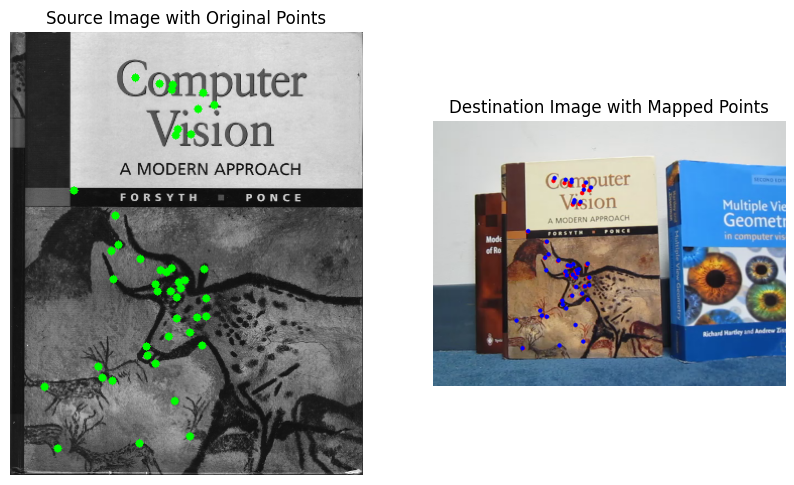

In [ ]:
def draw_points(img, points, color=(0, 255, 0), radius=4):
    """
    Draw points on the image using OpenCV.
    """
    for pt in points:
        cv.circle(img, tuple(np.int32(pt)), radius, color, -1) #don't draw the circle outline

def visualize_mapping(img1, img2, src_pts, dst_pts, mapped_pts):
    """
    Visualize the mapped points from img1 to img2.
    """
    img1_copy = img1.copy()
    img2_copy = img2.copy()

    # Draw the original points on img1
    draw_points(img1_copy, src_pts, color=(0, 255, 0))  # Green for original points
    # Draw the destination points on img2
    draw_points(img2_copy, dst_pts, color=(255, 0, 0))  # Red for destination points
    # Draw the mapped points on img2
    draw_points(img2_copy, mapped_points, color=(0, 0, 255))  # Blue for mapped points

    # Show the images
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img1_copy)
    plt.title('Source Image with Original Points')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2_copy)
    plt.title('Destination Image with Mapped Points')
    plt.axis('off')

    plt.show()

visualize_mapping(image1, frame_copy, source_points, dest_points, mapped_points)

# 1.3 Calculate Book Coordinates

In [ ]:
def get_corners_original_image(book_img,frame):
    # assuming the corners of the book are the corners of the original image
    h, w = book_img.shape[:2]

    book_corners = np.array([
        [0.0, 0.0],        # top-left
        [float(w), 0.0],   # top-right
        [float(w), float(h)],  # bottom-right
        [0.0, float(h)]    # bottom-left
    ], dtype=np.float32).reshape(-1,1,2) # whatever number of rows, 1 column, depth 2?

    projected_corners = cv.perspectiveTransform(book_corners, H)
    # Convert projected points to int and reshape
    pts = np.int32(projected_corners).reshape((-1, 1, 2))

    # Draw the polygon
    frame_with_corners = cv.polylines(frame.copy(), [pts], isClosed=True, color=(0, 255, 0), thickness=3)
    # showing frame with corners

    plt.imshow(frame_with_corners)
    plt.title("Corners on frame")
    plt.axis("off")
    plt.show()
    return pts


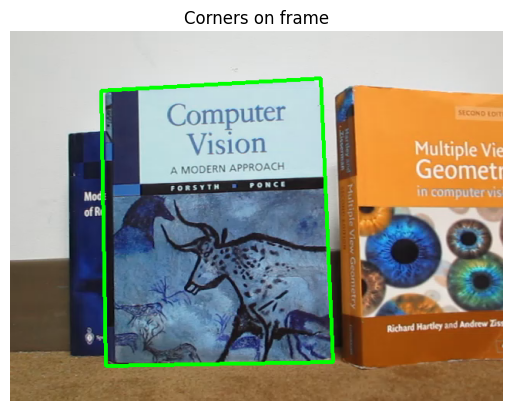

corners:
 [[[118  77]]

 [[403  61]]

 [[419 429]]

 [[124 434]]]


In [ ]:
corners_in_frame = get_corners_original_image(image1, frame.copy()) # send frame copy cuz we draw on it
print("Corners:\n", corners_in_frame)

In [ ]:
# def detect_book_corners(book_cover, video_frame):
#     """
#     Detect book corners in a video frame using feature matching and homography
    
#     Args:
#         book_cover: The book cover image (template)
#         video_frame: The video frame where to find the book
#         feature_detector: 'SIFT' or 'ORB'
    
#     Returns:
#         corners: Detected corners in video frame [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
#         visualization: Image with detected corners drawn
#     """

#     kp11 = np.float32(kp1).reshape(-1,1,2)
#     kp22 = np.float32(kp2).reshape(-1,1,2)
#     H, mask = cv.findHomography(kp11, kp22, cv.RANSAC, 5.0)
    
#     # 7. Get book cover corners in video frame
#     h, w = book_cover.shape[:2]
#     cover_corners = np.float32([[0,0], [w-1,0], [w-1,h-1], [0,h-1]]).reshape(-1,1,2)
#     video_corners = cv.perspectiveTransform(cover_corners, H)
    
#     # 8. Convert to simple coordinate list
#     corners = [np.int32(c[0]) for c in video_corners]
    
#     # 9. Create visualization
#     vis = cv.drawMatches(book_cover, keypoints1, video_frame, keypoints2, goodMatches1, None,
#                          flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
#     # Draw quadrilateral around book
#     for i in range(4):
#         cv.line(vis, 
#                 (w + corners[i][0], corners[i][1]),
#                 (w + corners[(i+1)%4][0], corners[(i+1)%4][1]),
#                 (0,255,0), 3)
    
#     return corners, vis,H
    
# # Detect corners
# corners, visualization , H= detect_book_corners(image1, frame)

# print("Detected corners:")
# for i, (x,y) in enumerate(corners):
#     print(f"Corner {i+1}: ({x}, {y})")

# # Show results
# cv.imshow("Book Detection", visualization)
# cv.waitKey(0)
# cv.destroyAllWindows()

Detected corners:
Corner 1: (118, 77)
Corner 2: (403, 61)
Corner 3: (418, 429)
Corner 4: (124, 433)


In [ ]:
# def detect_book_corners(book_cover, video_frame, H,feature_detector='SIFT'):
#     """
#     Detect book corners in a video frame using feature matching and homography.
    
#     Args:
#         book_cover: Template image (the book cover)
#         video_frame: Target frame to locate the book in
#         feature_detector: 'SIFT' or 'ORB'
    
#     Returns:
#         corners: Transformed corner coordinates in video_frame
#         vis: Visualization image showing matches + corner overlay
#     """
#     # 1. Initialize detector
#     if feature_detector == 'SIFT':
#         detector = cv.SIFT_create()
#         matcher = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
#     elif feature_detector == 'ORB':
#         detector = cv.ORB_create()
#         matcher = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
#     else:
#         raise ValueError("Unsupported detector. Use 'SIFT' or 'ORB'.")

#     # 2. Detect features
#     # kp1, desc1 = detector.detectAndCompute(book_cover, None)
#     # kp2, desc2 = detector.detectAndCompute(video_frame, None)

#     # 3. Match features
#     matches = matcher.match(descriptor1, descriptor2)
#     good_matches = sorted(matches, key=lambda x: x.distance)[:50]

#     # 4. Extract matched points
#     # src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
#     # dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

#     # 5. Find homography: from book_cover to video_frame
#     # H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

#     # 6. Map the four corners of the book_cover
#     h, w = book_cover.shape[:2]
#     corners_cover = np.float32([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]]).reshape(-1, 1, 2)
#     corners_frame = cv.perspectiveTransform(corners_cover, H)
#     corners = [tuple(map(int, pt[0])) for pt in corners_frame]  # list of (x, y)

#     # 7. Draw matches between the two images
#     vis = cv.drawMatches(book_cover, keypoints1, video_frame, keypoints2, good_matches, None,
#                          flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#     # 8. Draw corners on the right image (video frame side)
#     offset_x = w  # because right image starts after width of left image
#     for i in range(4):
#         pt1 = (offset_x + corners[i][0], corners[i][1])
#         pt2 = (offset_x + corners[(i+1)%4][0], corners[(i+1)%4][1])
#         cv.line(vis, pt1, pt2, (0, 255, 0), 3)

#         # Optional: draw corner circles too
#         cv.circle(vis, pt1, 5, (0, 0, 255), -1)  # Red dots at corners

#     return corners, vis

# corners ,visualization = detect_book_corners(image1, frame,H)
# print("Book corners in frame:")
# for i, (x, y) in enumerate(corners):
#     print(f"Corner {i+1}: ({x}, {y})")

# cv.imshow("Book Corners + Matches", visualization)
# cv.waitKey(0)
# cv.destroyAllWindows()


Book corners in frame:
Corner 1: (118, 77)
Corner 2: (403, 61)
Corner 3: (418, 429)
Corner 4: (124, 433)


In [ ]:
# def detect_book_corners(book_cover, video_frame, H):
#     """
#     Detect and visualize book corners in a video frame using a homography matrix.

#     Args:
#         book_cover: Template image (the book cover)
#         video_frame: Target frame (e.g., from video)
#         H: Homography matrix from book_cover to video_frame

#     Returns:
#         corners: List of (x, y) points of detected corners in video_frame
#         vis: Side-by-side image showing only corner correspondences
#     """
#     h1, w1 = book_cover.shape[:2]
#     h2, w2 = video_frame.shape[:2]

#     # Resize video_frame to match height of book_cover for side-by-side display
#     if h1 != h2:
#         scale = h1 / h2
#         video_frame = cv.resize(video_frame, (int(w2 * scale), h1))
#         h2, w2 = video_frame.shape[:2]  # Update size

#     # 1. Define corners in book_cover
#     corners_cover = np.float32([[0, 0], [w1 - 1, 0], [w1 - 1, h1 - 1], [0, h1 - 1]]).reshape(-1, 1, 2)

#     # 2. Transform corners using homography
#     corners_frame = cv.perspectiveTransform(corners_cover, H)
#     corners = [tuple(map(int, pt[0])) for pt in corners_frame]

#     # 3. Create visualization image (side-by-side)
#     vis = np.hstack((book_cover, video_frame))
#     # offset_x = w  # right image starts after book_cover width

#     # 4. Draw only corner matches
#     # for i in range(4):
#     #     pt_cover = tuple(map(int, corners_cover[i][0]))  # Point in book_cover
#     #     pt_frame = tuple(map(int, corners_frame[i][0]))  # Transformed point in video_frame
#     #     pt_frame_offset = (pt_frame[0] + offset_x, pt_frame[1])

#     #     # Draw corner points
#     #     cv.circle(vis, pt_cover, 6, (0, 255, 0), -1)           # Green on book
#     #     cv.circle(vis, pt_frame_offset, 6, (0, 0, 255), -1)    # Red on frame

#     #     # Draw line between them
#     #     cv.line(vis, pt_cover, pt_frame_offset, (255, 0, 0), 2)

#     offset_x = w1  # because right image starts after width of left image
#     for i in range(4):
#         pt1 = (offset_x + corners[i][0], corners[i][1])
#         pt2 = (offset_x + corners[(i+1)%4][0], corners[(i+1)%4][1])
#         cv.line(vis, pt1, pt2, (0, 255, 0), 3)

#         # Optional: draw corner circles too
#         cv.circle(vis, pt1, 5, (0, 0, 255), -1)  # Red dots at corners

#     return corners, vis

# corners, visualization = detect_book_corners(image1, frame, H)

# print("Book corners in frame:")
# for i, (x, y) in enumerate(corners):
#     print(f"Corner {i+1}: ({x}, {y})")

# cv.imshow("Book Corners Only", visualization)
# cv.waitKey(0)
# cv.destroyAllWindows()


# 1.4 Crop AR Video Frames

In [ ]:
corners_in_frame
# bot-left
# bot-right
# top-right
# top-left

array([[118,  77],
       [403,  61],
       [419, 429],
       [124, 434]], dtype=int32)

In [ ]:
bl, br, tr, tl = corners_in_frame.reshape(-1,2)

In [ ]:
# Compute width (average of top and bottom edge lengths)
width_top = np.linalg.norm(tr - tl)   # linalg: euclidean distance
width_bottom = np.linalg.norm(br - bl)
width = (width_top + width_bottom) / 2.0

# Compute height (average of left and right edge lengths)
height_left = np.linalg.norm(bl - tl)
height_right = np.linalg.norm(br - tr)
height = (height_left + height_right) / 2.0

In [ ]:
aspect_ratio = width / height  # or height / width depending on need

In [378]:
import cv2
print(cv2.__version__)

4.11.0


In [ ]:
# Set desired crop size
target_width = width
target_height = height

# Open the input video
cap2 = cv.VideoCapture("assignment_2_materials\\Part_1\\ar_source.mov")

# Get original video dimensions and FPS
original_width = int(cap2.get(cv.CAP_PROP_FRAME_WIDTH))
original_height = int(cap2.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = cap2.get(cv.CAP_PROP_FPS)

# Calculate center crop coordinates
x1 = (original_width - target_width) // 2
y1 = (original_height - target_height) // 2
x2 = x1 + target_width
y2 = y1 + target_height

# Set up the video writer

# idk what's wrong with this :(
fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter('output.mp4', fourcc, fps, (target_width, target_height))

while cap2.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Crop the frame from center
    cropped_frame = frame[y1:y2, x1:x2]

    # Write the cropped frame
    out.write(cropped_frame)

cap2.release()
out.release()
cv2.destroyAllWindows()